In [1]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.layers import Dense, Dropout

figsize = (20, 4.5)

2023-05-23 10:27:41.260147: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 10:27:41.302481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 10:27:41.303002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 10:27:41.952855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Convolutional Neural Networks

## DL as Representation Learning

**A nice perspective on DNs is to view them as "space tranformation machines"**

<center>
<img src="assets/ann.png" width=60%/>
</center>

* The input is encoded in its natural space
* The first layer morphs the input into a transformed space and so on
* The last layer applies linear/logistic regression to a learned representation

## DL as Representation Learning

**From this perspective, DNs can act as automatic feature extractor**

This is _the_ reason why they work so well on certain domains

* E.g. images, audio, natural language processing
* ...Meaning domains with complex or perceptual representations

**Consider a digit recognition application**

With classical ML, one would need to:

* Design high quality features (which requires a lot of domain expertise)
* ...And then train a model

With DL, the first step can be (partially skipped)

**This is a _huge_ advantage!**

## Image Data

**We will try to use Deep Learning on image data**

In particular we will use the [MNIST Digit Recognition Dataset](http://yann.lecun.com/exdb/mnist/)

* Code to download MNIST is available directy in Keras

In [2]:
from keras.datasets import mnist
# load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


The MNIST data is now stored in pairs of numpy arrays.

* The `x_train` and `x_test` arrays contain the greyscale value of each pixel
* The `y_train` and `y_test` arrays contain the class (digit) as an integer

## Image Data

**Let's inspect the output**

In [3]:
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')
n_tr = y_train.shape[0]
n_ts = y_test.shape[0]

Shape of y_train: (60000,)
Shape of y_test: (10000,)


* There are 60,000 training examples
* ...And 10,000 test examples

**The target arrays are one-dimensional**

Let's check a sample:

In [4]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Image Data

**Let's inspect the input**

In [5]:
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')
x_h = x_train.shape[1]
x_w = x_train.shape[2]

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


* The dataset input consists of 28x28 matrices

In [6]:
print(f'Minimum: {x_train.min()} (train), {x_train.min()} (test)')
print(f'Maximum: {x_train.max()} (train), {x_train.max()} (test)')

Minimum: 0 (train), 0 (test)
Maximum: 255 (train), 255 (test)


* The content of the matrix cells ranges from 0 to 255
* ...And it represents 8 bit brightness values

## Image Data

**Let's see some sample images**

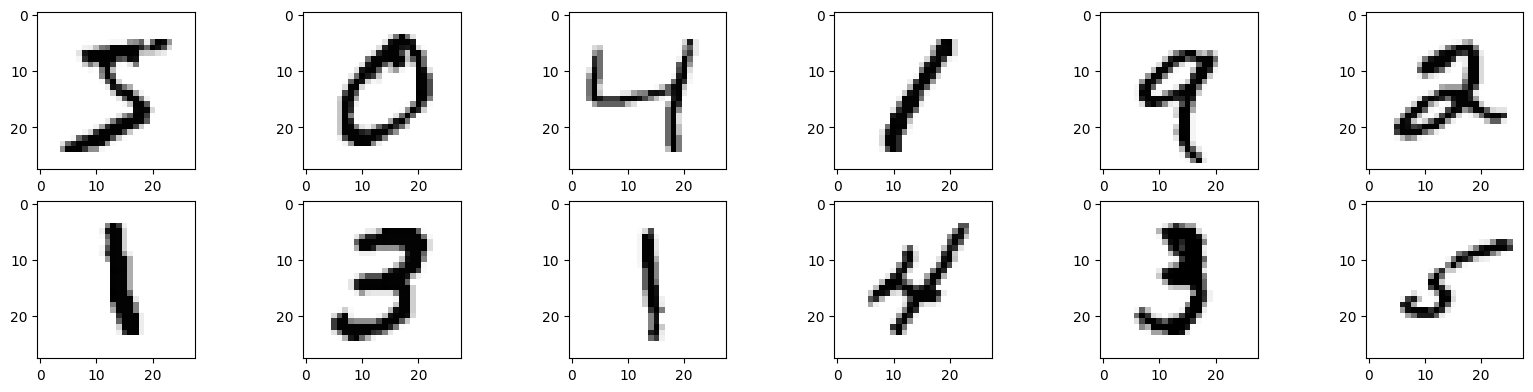

In [7]:
m, n = 2, 6
plt.figure(figsize=figsize)
for i in range(m):
    for j in range(n):
        plt.subplot(m, n, i*n + j + 1)
        plt.imshow(x_train[i*n + j], cmap='Greys')
plt.show()

## Preprocessing

**Before we can start training we need to do some preprocessing**

We will apply a _min-max encoding to the input_

* ...Since minima and maxima are clearly define

In [8]:
x_train_norm = x_train / 255.0
x_test_norm = x_test / 255.0

We will adopt a _one-hot encoding for the output_

* ...Since we will need to build a network with one neuron per class
* Keras provides a utility function for the conversion

In [9]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)
y_train_cat[:2, :]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Adding Channel Information

**When working with image data, one extra step is needed**

...Since images are not necessarily greyscale!

* Color images are often represented using the RGB color space
* ...I.e. each pixel has an associated value for the red, green, and blue hue.

For this reason, an image is best described by a _tensor_ not a matrix

* An $i, j$ pair identifies a pixel
* ...And a third dimension specifies the channel (RGB)

**Even if we have a single channel, is best to make Keras aware of that**

In [10]:
x_train_c = x_train_norm.reshape(-1, x_h, x_w, 1)
x_test_c = x_test_norm.reshape(-1, x_h, x_w, 1)
input_shape = (x_h, x_w, 1)
output_shape = (10,)
print(f'New shape of the training set: {x_train_c.shape}')

New shape of the training set: (60000, 28, 28, 1)


## Training a Baseline Model

**As a baseline, we will build an MLP model**

In [11]:
def build_mlp(input_shape, output_shape, hidden, rate=0.05):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    mdl.add(keras.layers.Flatten())
    for k, h in enumerate(hidden):
        mdl.add(Dense(h, activation='relu'))
        mdl.add(keras.layers.Dropout(rate))
    mdl.add(Dense(output_shape[0], activation='softmax'))
    return mdl

**A classical MLP is not designed to handle images**

* ...For this reason with start with a special `Flatten` layer
* ...Which discards all tensor dimensions (except the number of samples)

**We also need to build one output neuron per class**

* ...And we need to use a softmax activation function

## Training a Baseline Model

**We can now train a 2-layer network as a baseline**

In [12]:
def train_nn(nn, X_tr, y_tr, batch_size, epochs, verbose=1):
    nn.compile(loss='categorical_crossentropy', optimizer='adam')
    history = nn.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, verbose=verbose)
    cols = [k for k in history.history.keys()]
    vals = np.array([history.history[c] for c in cols]).T
    return pd.DataFrame(data=vals, columns=cols)

nn1 = build_mlp(input_shape, output_shape, hidden=[16, 16])
history = train_nn(nn1, x_train_c, y_train_cat, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
1875/1875 [==============================] - 2s 776us/step - loss: 0.5817
Epoch 2/30
1875/1875 [==============================] - 1s 770us/step - loss: 0.3378
Epoch 3/30
1875/1875 [==============================] - 1s 757us/step - loss: 0.2952
Epoch 4/30
1875/1875 [==============================] - 1s 764us/step - loss: 0.2699
Epoch 5/30
1875/1875 [==============================] - 1s 758us/step - loss: 0.2539
Epoch 6/30
1875/1875 [==============================] - 1s 766us/step - loss: 0.2422
Epoch 7/30
1875/1875 [==============================] - 1s 764us/step - loss: 0.2321
Epoch 8/30
1875/1875 [==============================] - 2s 835us/step - loss: 0.2275
Epoch 9/30
1875/1875 [==============================] - 1s 767us/step - loss: 0.2195
Epoch 10/30
1875/1875 [==============================] - 1s 767us/step - loss: 0.2139
Epoch 11/30
1875/1875 [==============================] - 1s 765us/step - loss: 0.2101
Epoch 12/30
1875/1875 [==============================] - 1s 770

Training takes considerably longer then before

* ...Since we have more data and with higher dimensionality

Since we have more data, we need fewer epochs

* ...Due our choice of using a small batch size

## Training a Baseline Model

**Let's inspect the training curve**

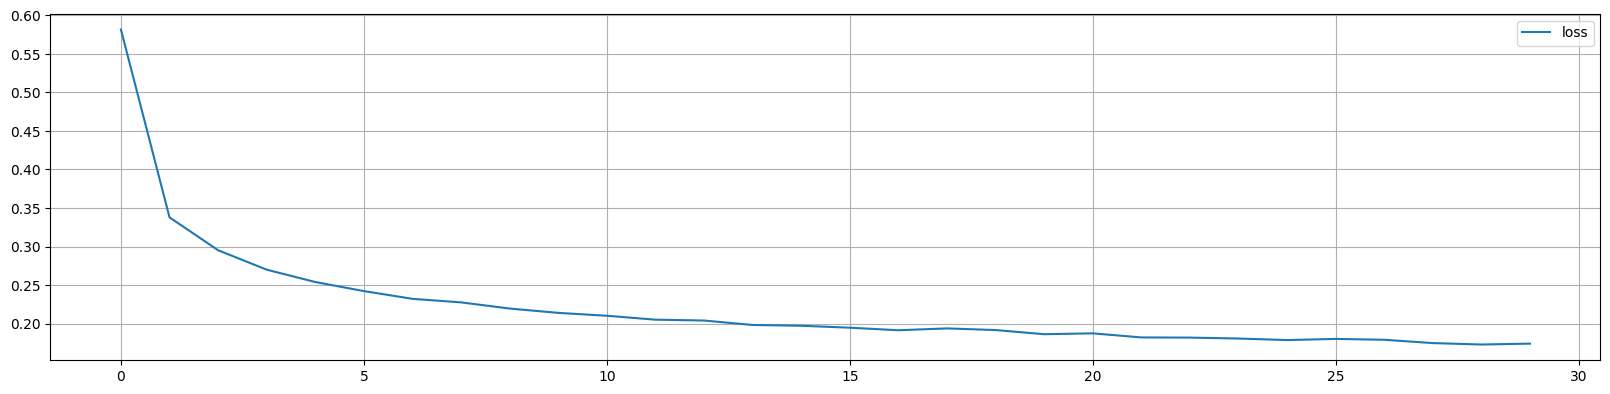

In [13]:
history.plot(figsize=figsize, grid=':');

There's still something to go before convergence, but we'll stop here

## Evaluation

**Now we can compute the model accuracy**

In [14]:
nn1_p_tr = nn1.predict(x_train_c, verbose=0).argmax(axis=1)
nn1_p_ts = nn1.predict(x_test_c, verbose=0).argmax(axis=1)

nn1_acc_tr = accuracy_score(y_train, nn1_p_tr)
nn1_acc_ts = accuracy_score(y_test, nn1_p_ts)

print(f'2-layer network accuracy: {nn1_acc_tr:.3f} (train), {nn1_acc_ts:.3f} (test)')

2-layer network accuracy: 0.968 (train), 0.953 (test)


We are doing already pretty well!

* What can we do to improve the results?
* Beyond "stacking more layers" the answer is not clear

## Exploiting Structural Information

**DNs are very flexible learning models**

* ...Since we can choose both how many layer to use
* ...And how big they should be

**However, it's difficult to develop an intuition of which options work**

* This is due to the poor interpretability of DNs
* ...To the point that a [fully fledged research field](https://en.wikipedia.org/wiki/Automated_machine_learning) focuses on automatic tuning

**There is one type of choice that is intuitive and has a big impact**

...This concerns the idea of exploiting structural information

* For example, nearby pixels in an image may be semantically linked
* ...And the same goes for nearby points in time
* ...Or nearby words in a sentence

## Convolutional Layers

**This idea is at the basis of _convolutional layers_**

A 2D convolution layer...

* Starts from an input tensor with shape (m, n, c)
* ...And slides a linear $n_f, m_f$ filter (or kernel) on top of the image
* ...With a certain step size (stride)

<center>
<img src="assets/pooling.png" width=50%/>
</center>

* You can think of that as moving an $n_f, m_f$ mask across an image
* The figure shows a 2x2 convolution with stride 2

## Convolutional Layers

**Each application of the kernel...**

* Compute a dot product (involving all channels) to obtain a scalar
* ...The optionally applies an activation function

Here we see the effect along 1 dimension:

<center>
<img src="assets/convstack0.png" width=60%/>
</center>

**Therefore, by applying a $(m_f, n_f)$ 2D convolution to an $(m, n, c)$ tensor**

...We get a $(m-m_f+1, n-n_f+1)$ output tensor

* Intuitively, starting from a multi-channel image
* ...We get a slightly smaller single-channel image

## Convolutional Layers

**If we don't want to reduce the image size**

* ...We can include some padding

**If we want to undersample the image**

* ...We can use a non unary stride

**If we use multiple filters for the same level**

* ...We obtain multiple output "images"

**If we stack multiple convolutional layers**

* ...Later layers will be able to access information from a larger _receptive field_

<center>
<img src="assets/convstack1.png" width=50%/>
</center>

## Convolutional Layers

**Convolutional layers have some interesting properties**

Their weights are associated _only to the filter_

* So, if we have $c$ channels and a $(m_f, n_f)$ filter
* ...We have $m_f n_f c$ weights _regardless of the input size_

This allows a _huge_ reduction in terms of number of weights

**The price to pay is a _higher bias_**

...But the trick is that it's _a bias that makes sense_!

* Intuitively, filters will learn to recognize _local features_
* Earlier convolutions will focus on fine-grain details
* ...While later convolution will aggregate them

**This property allows CNN to work very well on image data** 

## CNNs in Keras

**Convolutional layer are available in Keras as `Conv2D` objects**

In [15]:
from keras.layers import Conv2D

def build_cnn(input_shape, output_shape, hidden, convs, rate=0.05):
    mdl = keras.Sequential()
    mdl.add(keras.Input(shape=input_shape))
    for nf in convs:
        mdl.add(Conv2D(nf, kernel_size=(3,3), activation='relu'))
    mdl.add(keras.layers.Flatten())
    for h in hidden:
        mdl.add(Dense(h, activation='relu'))
        mdl.add(keras.layers.Dropout(rate))
    mdl.add(Dense(output_shape[0], activation='softmax'))
    return mdl

* The first parameter is the number of filters
* Then we have the filter (kernel) size and the activation function

## Training a CNN

**CNNs can be trained as usual, but the process is much slower**

...Since even with few weights, we still need to do a lot of computations

* Using GPUs can considerably accelerate this step

In [16]:
cnn1 = build_cnn(input_shape, output_shape, hidden=[16], convs=[16])
history2 = train_nn(cnn1, x_train_c, y_train_cat, batch_size=32, epochs=30, verbose=1)

Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2865
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1106
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0858
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0692
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0579
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0489
Epoch 7/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0421
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0355
Epoch 9/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0328
Epoch 10/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0284
Epoch 11/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0276
Epoch 12/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0250
E

## Training a CNN

**Let's check the training curve**

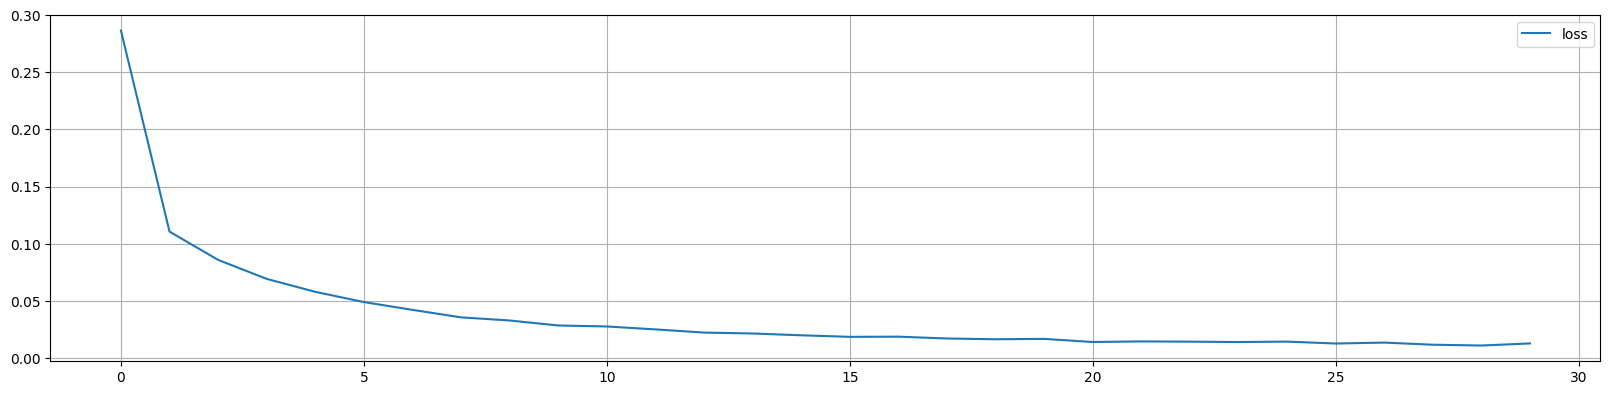

In [17]:
history2.plot(figsize=figsize, grid=':');

Again, there is still some way to go, but we'll stop here for a fair comparison

## Quality Evaluation

In [19]:
cnn1_p_tr = cnn1.predict(x_train_c, verbose=0).argmax(axis=1)
cnn1_p_ts = cnn1.predict(x_test_c, verbose=0).argmax(axis=1)

cnn1_acc_tr = accuracy_score(y_train, cnn1_p_tr)
cnn1_acc_ts = accuracy_score(y_test, cnn1_p_ts)

print(f'Shallow network accuracy: {nn1_acc_tr:.3f} (train), {nn1_acc_ts:.3f} (test)')
print(f'Convolutional network accuracy: {cnn1_acc_tr:.3f} (train), {cnn1_acc_ts:.3f} (test)')

Shallow network accuracy: 0.968 (train), 0.953 (test)
Convolutional network accuracy: 0.999 (train), 0.981 (test)


The results are much better!

* Even if the CNN has much fewer weights than the fully connected one
* ...And the same number of hidden layers

**Exploiting structural information is a powerful idea in DL**

* Rather than focusing o low-level design choices (e.g. crafting features)
* ...We focus on building architecture that can exploit general properties